In [6]:
%pip install -q pandas pydicom Pillow scipy opencv-python matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd

import os
import csv
import shutil
from collections import defaultdict
from PIL import Image
import numpy as np
import pydicom
from scipy import stats
import cv2
import matplotlib.pyplot as plt

# Filtrado de imágenes

In [8]:

# Load the annotations
df = pd.read_csv('finding_annotations.csv')

# Diccionario anidado
study_dict = defaultdict(dict)

with open('finding_annotations.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        study_id = row['study_id']
        image_id = row['image_id']
        # Excluimos study_id e image_id de los datos asociados
        data = {k: v for k, v in row.items() if k not in ['study_id', 'image_id']}

        if str(data['finding_categories']).lower().find('mass') != -1:
            study_dict[study_id].setdefault(image_id, [])
            study_dict[study_id][image_id].append(data)


outdirname = 'filtered'
if os.path.exists("images"):
    for study_id, images in study_dict.items():
        for image_id, data in images.items():
            path = os.path.join('images', study_id, image_id + '.dicom')

            if os.path.exists(path):
                # Out directory
                out = os.path.join(outdirname, study_id, image_id + '.dicom')

                # Create the directory for the study_id if it doesn't exist
                os.makedirs(os.path.join(outdirname, study_id), exist_ok=True)

                shutil.copy(path, out)

# Remove images directory
shutil.rmtree('images', ignore_errors=True)

# Preprocesamiento

[4e3a578fe535ea4f5258d3f7f4419db8.dicom] Pixeles válidos: 1303290 de 9850400 (13.23%)
[dac39351b0f3a8c670b7f8dc88029364.dicom] Pixeles válidos: 1678649 de 9850400 (17.04%)
[2f944efb1cb9579442df2d7fe6a579b7.dicom] Pixeles válidos: 1667635 de 9850400 (16.93%)
[7385e8cf7b29764525c81de4aa1aebe4.dicom] Pixeles válidos: 2450486 de 9850400 (24.88%)
[f581ef53bb7e61f4575db33eceac8ff8.dicom] Pixeles válidos: 1207502 de 9850400 (12.26%)
[1142cdfbfe725d62038252693cf064e5.dicom] Pixeles válidos: 2166828 de 9850400 (22.00%)
[5a94dd668eaa9865b907450c37db6ecc.dicom] Pixeles válidos: 1394132 de 9850400 (14.15%)
[2bbe58aab434b2a6af7e873ca9adc56d.dicom] Pixeles válidos: 1935957 de 9850400 (19.65%)
[84327b97a8195be40744b4983d5f7cbe.dicom] Pixeles válidos: 1094133 de 9850400 (11.11%)
[d51acb58b7bbec42dc749b5463863c6f.dicom] Pixeles válidos: 1563374 de 9850400 (15.87%)
[dc4694b543793f89c7003f4d52adbbcb.dicom] Pixeles válidos: 1296328 de 9850400 (13.16%)
[040cc172596bded4092c44094dc33fb7.dicom] Pixeles válid

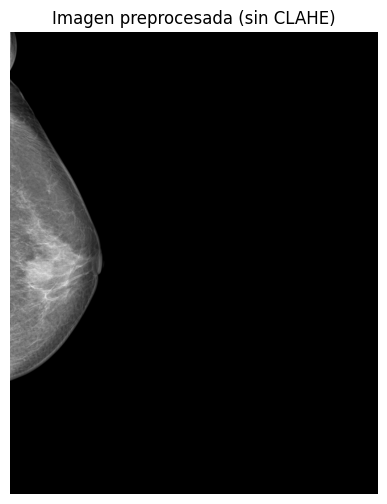

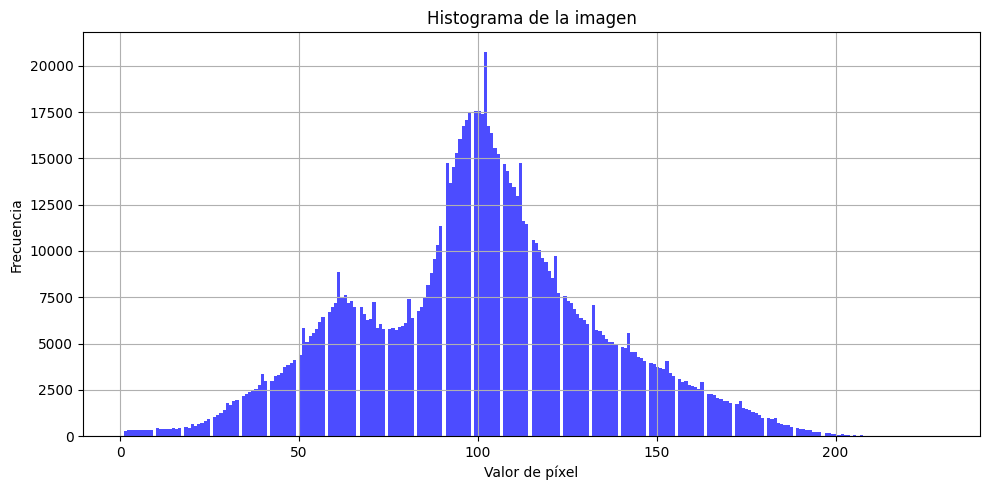

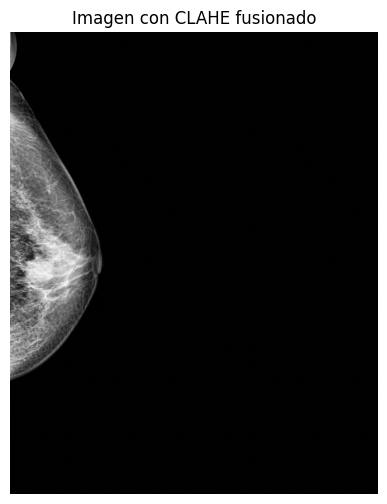

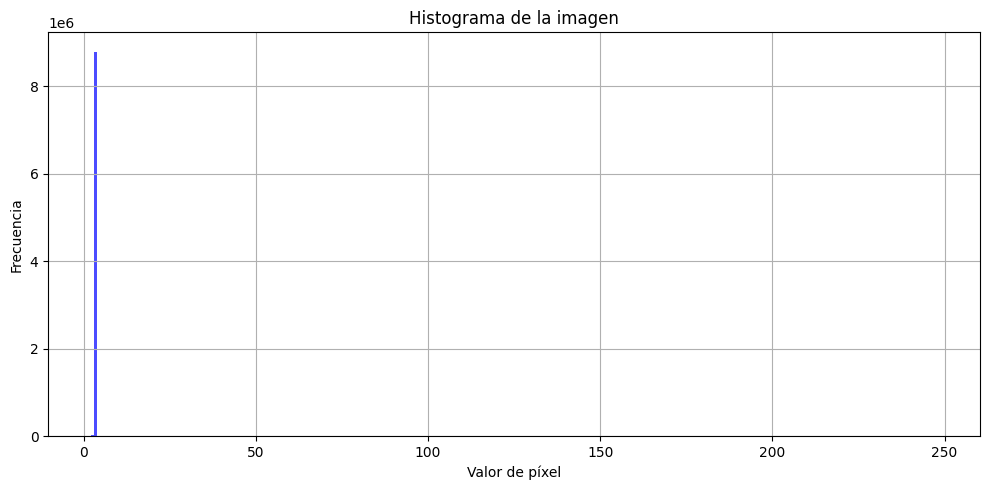

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os

def show_histogram(image):
    flat = image.flatten()
    flat = flat[flat != 0]  # Excluir ceros (máscara)

    plt.figure(figsize=(10, 5))
    plt.hist(flat, bins=256, color='blue', alpha=0.7)
    plt.title("Histograma de la imagen")
    plt.xlabel("Valor de píxel")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def apply_multiple_clahe_and_merge(image):
    # image debe estar en uint8, escala 0-255
    image = image.astype(np.uint8)

    clahe1 = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8)).apply(image).astype(np.float32)
    clahe2 = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8)).apply(image).astype(np.float32)
    clahe3 = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)).apply(image).astype(np.float32)

    # Normalizar para fusionar
    clahe1 /= 255.0
    clahe2 /= 255.0
    clahe3 /= 255.0

    # Pesos para fusionar, ajustables
    merged = (0.3 * clahe1 + 0.4 * clahe2 + 0.3 * clahe3)

    merged = np.clip(merged * 255.0, 0, 255).astype(np.uint8)
    return merged

def preprocess(path, data):
    ds = pydicom.dcmread(path)
    pixels = ds.pixel_array.astype(np.int16)

    valores_excluidos = {0, 2624}
    mask_valida = ~np.isin(pixels, list(valores_excluidos))
    foreground = pixels[mask_valida]

    valores_positivos = foreground - foreground.min()
    modo_idx = np.bincount(valores_positivos).argmax()
    mode_val = foreground.min() + modo_idx

    lower = mode_val - 500
    upper = mode_val + 800
    clipped = np.clip(pixels, lower, upper)
    scaled = ((clipped - lower) / (upper - lower)) * 255.0
    scaled = np.clip(scaled, 0, 255).astype(np.uint8)

    scaled = scaled * mask_valida

    # Aplicar CLAHE fusionado
    scaled_clahe = apply_multiple_clahe_and_merge(scaled)

    return scaled, scaled_clahe

# === Preprocesar todas las imágenes y guardar (puedes omitir si solo haces pruebas) ===
outdirname = 'preprocessed'
for study_id, images in study_dict.items():
    for image_id, data in images.items():
        path = os.path.join('filtered', study_id, image_id + '.dicom')

        if os.path.exists(path):
            out = os.path.join(outdirname, study_id, image_id + '.png')
            os.makedirs(os.path.join(outdirname, study_id), exist_ok=True)

            scaled, scaled_clahe = preprocess(path, data)
            cv2.imwrite(out, scaled_clahe)  # o 'scaled' si prefieres sin CLAHE

# === Visualización de un ejemplo específico ===
study_id = 'd540a38fcac9ff0136535fb45fa45dda'
image_id = 'f9918b3feb92e1f38a0c86a6a28c14a0'
path = os.path.join('filtered', study_id, image_id + '.dicom')

scaled, scaled_clahe = preprocess(path, data=None)

# Mostrar imagen original preprocesada (sin CLAHE)
plt.figure(figsize=(6, 6))
plt.imshow(scaled, cmap='gray')
plt.title('Imagen preprocesada (sin CLAHE)')
plt.axis('off')
plt.show()
show_histogram(scaled)

# Mostrar imagen con CLAHE fusionado
plt.figure(figsize=(6, 6))
plt.imshow(scaled_clahe, cmap='gray')
plt.title('Imagen con CLAHE fusionado')
plt.axis('off')
plt.show()
show_histogram(scaled_clahe)

